In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import shelve
import torch
import numpy as np

# COLLAB

In [3]:
dataset = CollabDataset(seed=12345)

In [4]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=5)
model.load_state_dict(torch.load('ckpts/collab.pt'))

<All keys matched successfully>

In [5]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.8528000116348267,
 'cm': array([[2297,  109,  194],
        [ 161,  586,   28],
        [ 223,   21, 1381]], dtype=int64),
 'f1': {'High Energy': 0.8699110150337219,
  'Condensed Matter': 0.7860496044158936,
  'Astro': 0.8556381464004517}}

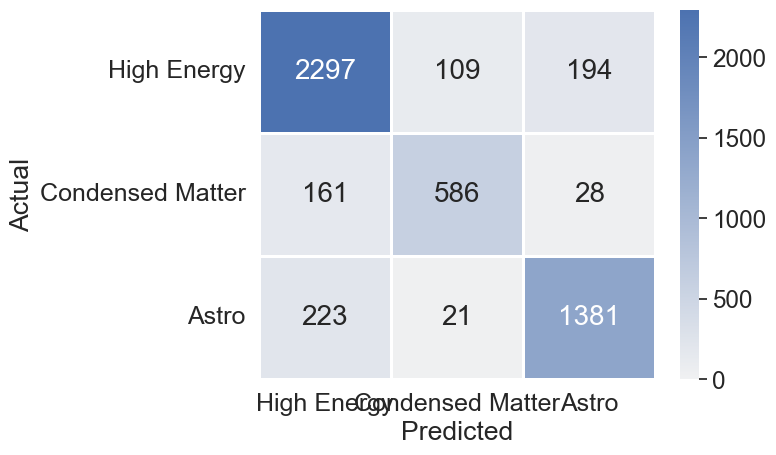

In [7]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [8]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


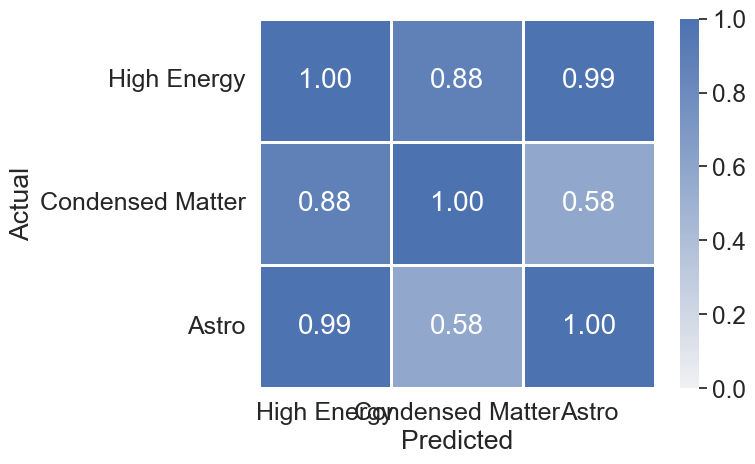

In [9]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [10]:
trainer = {}
sampler = {}

# 0 & 1

In [11]:
cls_1, cls_2 = 0, 1
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(classes=[cls_1, cls_2]), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
)

In [12]:
trainer[0, 1].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=30,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 1/2000 [00:00<30:12,  1.10it/s, size=23.1, bpw=1, High Energy=0.0138, Condensed Matter=-7.58, Astro=-.624]


True

n=18 m=23
logits=[0.6928107738494873, 0.5309526920318604, -1.1019999980926514]
probs=[0.4958544671535492, 0.4217549264431, 0.08239062875509262]


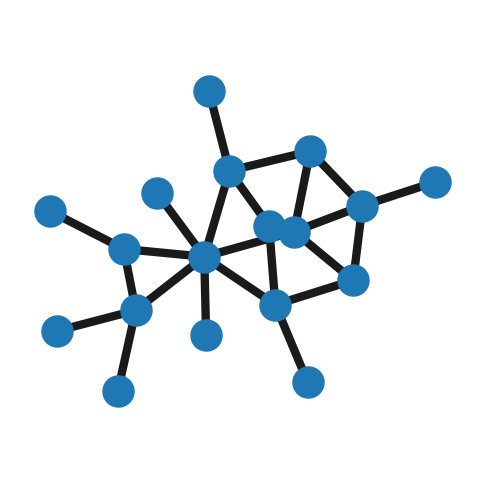

In [14]:
trainer[0, 1].evaluate(threshold=0.5, show=True)

# 0 & 2

In [15]:
cls_1, cls_2 = 0, 2
trainer[cls_1, cls_2] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(classes=[cls_1, cls_2]), weight=25),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=2),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1)
)

In [16]:
trainer[0, 2].train(
    iterations=2000,
    target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
    target_size=30,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 6/2000 [00:01<05:52,  5.66it/s, size=15, bpw=1, High Energy=-.874, Condensed Matter=-5.7, Astro=1.5]        


True

n=19 m=13
logits=[-0.19033628702163696, -3.9704902172088623, -0.11948789656162262]
probs=[0.47704511880874634, 0.010885778814554214, 0.512069046497345]


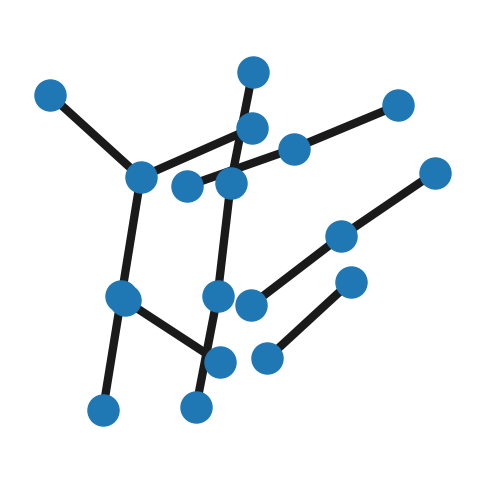

In [18]:
trainer[0, 2].evaluate(threshold=0.5, show=True)